# Conditional spherical Gaussian experiment: inference results

## Setup

In [1]:
%matplotlib inline

import sys
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import torch
from torch.utils.data import TensorDataset
import logging
from mpl_toolkits.mplot3d import Axes3D

sys.path.append("../../")

logging.basicConfig(
    format="%(asctime)-5.5s %(name)-30.30s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.DEBUG,
)
logger = logging.getLogger(__name__)
# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "manifold_flow" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)


## Load results

In [2]:
algo_filenames = [
    "flow",
    "pie",
    #"mf",
    "gamf",
    #"mf_specified",
    # "pie_specified"
]
algo_additionals = [
    "",
    "",
    #"",
    "", 
    #"", 
    # "", 
]
algo_labels = [
    "Flow",
    "PIE",
    #"Manifold flow (simple)",
    "GAMF",
    #"Specified MF",
    #"Specified PIE"
]

setup_filenames = [
    "2_3_0.010",
    #"2_3_0.001",
    #"2_3_0.100",
]


In [3]:
def load(name, shape, numpyfy=True, result_dir="../data/results"):
    all_results = []
    
    for algo_filename in algo_filenames:
        results = []
        
        for setup_filename in setup_filenames:
            try:
                results.append(np.load(
                    "{}/{}_2_conditional_spherical_gaussian_{}_{}.npy".format(
                        result_dir, algo_filename, setup_filename, name
                    )
                ))
            except FileNotFoundError as e:
                print(e)
                results.append(np.nan*np.ones(shape))
            
        all_results.append(results)
    
    return np.asarray(all_results) if numpyfy else all_results

true_posterior_samples = load("true_posterior_samples", (1000,2))
model_posterior_samples = load("model_posterior_samples", (1000, 2))
mmds = load("mmd", (1,))
true_test_log_likelihood = load("true_log_likelihood_test", (1000,))
model_test_log_likelihood = load("model_log_likelihood_test", (1000,))
model_test_reco_error = load("model_reco_error_test", (1000,))


## Plot samples

In [4]:
n = 1000

filename = "../data/samples/conditional_spherical_gaussian/conditional_spherical_gaussian_2_3_0.010_{}.npy"
x_train = np.load(filename.format("x_train"))[:n]
params_train = np.load(filename.format("parameters_train"))[:n]
x_test = np.load(filename.format("x_test"))[:n]
    

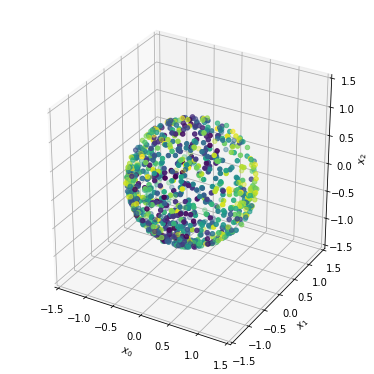

In [5]:
boundary = 1.5

fig = plt.figure(figsize=(5,5))
ax = Axes3D(fig)

ax.scatter(x_train[:,0], x_train[:,1], x_train[:,2], c=params_train[:,0], cmap="viridis")

ax.set_xlim(-boundary, boundary)
ax.set_ylim(-boundary, boundary)
ax.set_zlim(-boundary, boundary)
ax.set_xlabel("$x_0$")
ax.set_ylabel("$x_1$")
ax.set_zlabel("$x_2$")
    
plt.show()

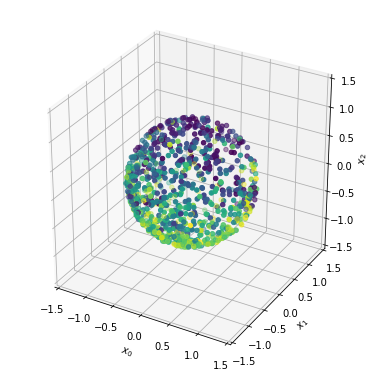

In [6]:
boundary = 1.5

fig = plt.figure(figsize=(5,5))
ax = Axes3D(fig)

ax.scatter(x_train[:,0], x_train[:,1], x_train[:,2], c=params_train[:,1], cmap="viridis")

ax.set_xlim(-boundary, boundary)
ax.set_ylim(-boundary, boundary)
ax.set_zlim(-boundary, boundary)
ax.set_xlabel("$x_0$")
ax.set_ylabel("$x_1$")
ax.set_zlabel("$x_2$")
    
plt.show()

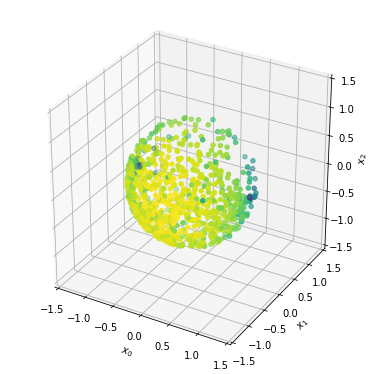

In [7]:
boundary = 1.5

fig = plt.figure(figsize=(5,5))
ax = Axes3D(fig)

ax.scatter(x_test[:,0], x_test[:,1], x_test[:,2], c=true_test_log_likelihood[0,0], cmap="viridis")

ax.set_xlim(-boundary, boundary)
ax.set_ylim(-boundary, boundary)
ax.set_zlim(-boundary, boundary)
ax.set_xlabel("$x_0$")
ax.set_ylabel("$x_1$")
ax.set_zlabel("$x_2$")
    
plt.show()

## Test likelihood

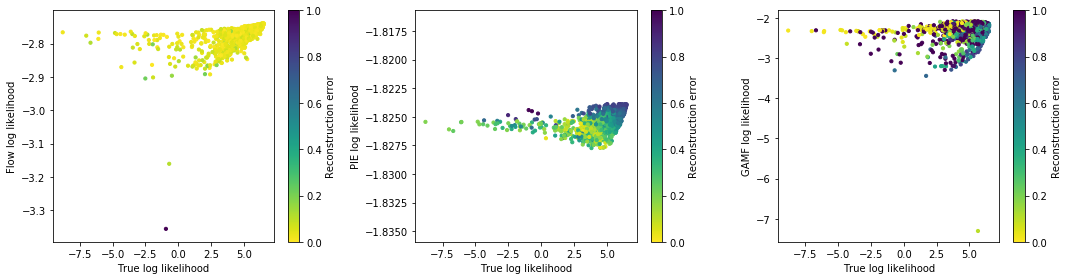

In [11]:
show = [0]

ncols = len(algo_labels)
nrows = len(show)

fig = plt.figure(figsize=(ncols*5, nrows*4))

for row, setting in enumerate(show):
    for col, algo_label in enumerate(algo_labels):
        ax = plt.subplot(nrows, ncols, setting*ncols + col + 1)
        
        sc = plt.scatter(
            true_test_log_likelihood[col, setting],
            model_test_log_likelihood[col, setting],
            c=model_test_reco_error[col, setting],
            s=10.,
            label=algo_label,
            cmap="viridis_r",
            vmin=0., vmax=1.
        )
        cbar = plt.colorbar(sc)
        
        plt.xlabel(r"True log likelihood")
        plt.ylabel(r"{} log likelihood".format(algo_label))
        cbar.set_label('Reconstruction error')
        
        # plt.xlim(-1.1,1.1)
        # plt.ylim(-1.1,1.1)
    
plt.tight_layout()
plt.savefig("../figures/test_likelihood_csg.pdf")



## MCMC results

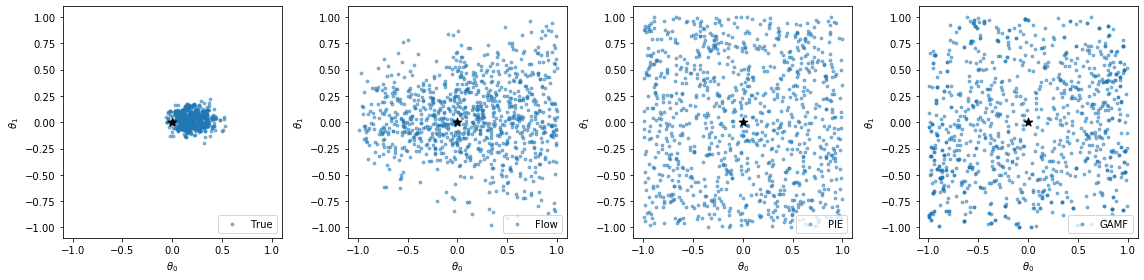

In [9]:
show = [0]

ncols = len(algo_labels) + 1
nrows = len(show)

fig = plt.figure(figsize=(ncols*4, nrows*4))

for row, setting in enumerate(show):
    for col, algo_label in enumerate(["True"] + algo_labels):
        ax = plt.subplot(nrows, ncols, setting*ncols + col + 1)

        if col == 0:
            plt.scatter(
                true_posterior_samples[col, setting,:,0],
                true_posterior_samples[col, setting,:,1],
                s=8., alpha=0.5, c="C0",
                label=algo_label
            )
        else:
            plt.scatter(
                model_posterior_samples[col - 1, setting,:,0],
                model_posterior_samples[col - 1, setting,:,1],
                s=8., alpha=0.5, c="C0",
                label=algo_label
            )
        plt.scatter([0.], [0.], s=80, marker="*", c="black")
        plt.legend(loc="lower right")
        
        plt.xlabel(r"$\theta_0$")
        plt.ylabel(r"$\theta_1$")
        plt.xlim(-1.1,1.1)
        plt.ylim(-1.1,1.1)
    
plt.tight_layout()
plt.savefig("../figures/posterior_samples_csg.pdf")


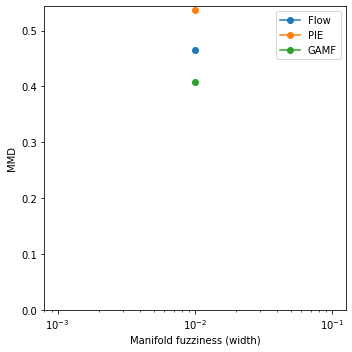

In [10]:
show = [0]  # [1, 0, 2]
xs = [0.01]  # [0.001, 0.01, 0.1]

fig = plt.figure(figsize=(5,5))

for mmds_, algo_label in zip(mmds, algo_labels):
    plt.plot(xs, mmds_[show], label=algo_label, ls="-", marker="o", ms=6.)
plt.legend()

plt.xscale("log")
plt.ylim(0., None)
plt.xlabel("Manifold fuzziness (width)")
plt.ylabel("MMD")

plt.tight_layout()
plt.savefig("../figures/mmd_vs_epsilon_csg.pdf")
